In [1]:
%reload_ext autoreload
%autoreload 2


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import MSTL
from sktime.transformations.series.boxcox import BoxCoxTransformer
from pmdarima.arima.utils import ndiffs, nsdiffs, diff

from src.custom_utils import S3Helper
from src.eda import ExploratoryDataAnalyzer

## Data

Source: [CTA - Ridership - Daily Boarding Totals](https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97)

Summary: This dataset shows boardings for both bus and rail services provided by CTA, dating back to 2001.

Ridership statistics are provided on a system-wide and bus route/station-level basis. Ridership is primarily counted as boardings, that is, customers boarding a transit vehicle (bus or rail). On the rail system, there is a distinction between station entries and total rides, or boardings. Datasets indicate such in their file name and description.

* **How people are counted on the rail**: On the rail system, a customer is counted as an "entry" each time he or she passes through a turnstile to enter a station.  Customers are not counted as "entries" when they make a "cross-platform" transfer from one rail line to another, since they don't pass through a turnstile. Where the number given for rail is in "boardings," what's presented is a statistically valid estimate of the actual number of boardings onto the rail system. 

* **How people are counted on buses**: Boardings are recorded using the bus farebox and farecard reader. In the uncommon situation when there is an operating error with the farebox and the onboard systems cannot determine on which route a given trip's boardings should be allocated, these boardings are tallied as Route 0 in some reports.  Route 1001 are shuttle buses used for construction or other unforeseen events.

* **Day type**: This field is coded as "W" for Weekday, "A" for Saturday and "U" for Sunday/Holidays.  Note that New Year's Day, Memorial Day, Independence Day, Labor Day, Thanksgiving, and Christmas Day are considered as "Sundays" for the purposes of ridership reporting. All other holidays are reported as the type of day they fall on.

### Forecasting Horizon

Forecasting rail and bus ridership can be essential for various business applications, including optimizing resource allocation, determining schedules, maintenance planning, and budgeting. The forecast horizon, or how many steps ahead we should forecast, will depend on the specific business application and planning needs. Here are some considerations:

1. **Short-Term Forecasting (1 day to 2 weeks ahead):**
   - **Purpose:** Daily operations, resource allocation (e.g., number of buses or trains needed), and immediate maintenance planning.
   - **Data Requirement:** High-frequency data, such as daily or even hourly ridership numbers.
   
2. **Medium-Term Forecasting (2 weeks to 6 months ahead):**
   - **Purpose:** Schedule planning, manpower allocation, marketing campaigns, and medium-term budgeting.
   - **Data Requirement:** Daily to weekly data points can be useful.
   
3. **Long-Term Forecasting (6 months to several years ahead):**
   - **Purpose:** Strategic planning, infrastructure investment decisions, long-term budgeting, and policy-making.
   - **Data Requirement:** Monthly, quarterly, or even yearly aggregated data can be more appropriate for this horizon.

**Factors to Consider:**

- **Business Cycle:** Consider the typical business cycle of the transportation industry in Chicago. For instance, if ridership significantly varies by season (e.g., more riders in summer due to tourism), then seasonal forecasting becomes crucial.
  
- **External Events:** Special events, holidays, or other external factors can have a notable impact on ridership. Recognizing these events and adjusting forecasts accordingly is essential. In this data set, the `day_type` field contains information about the day type of each observation.
  
- **Data Availability:** The richness and quality of your historical data play a significant role. For daily operations, daily (or even more granular) historical data is beneficial. For long-term strategic decisions, aggregated data might suffice.
  
- **Model Complexity:** More extended forecast horizons generally introduce more uncertainty. While short-term forecasts might benefit from intricate models that consider many factors, long-term forecasts might require simpler models due to the increased uncertainty and fewer actionable details available.
  
- **Operational Needs:** If the primary goal is to decide on a daily basis how many buses to deploy, then short-term forecasts are essential. Conversely, if we're making decisions about purchasing new buses or building new rail lines, long-term forecasts become crucial.

In [2]:
s3_helper = S3Helper()
data = s3_helper.read_parquet(obj_key="data/raw/chicago_cta_ridership.parquet")
data.shape

(8278, 5)

In [3]:
data.head(5)

,service_date,day_type,bus,rail_boardings,total_rides
0,01/01/2001,U,297192,126455,423647
1,01/02/2001,W,780827,501952,1282779
2,01/03/2001,W,824923,536432,1361355
3,01/04/2001,W,870021,550011,1420032
4,01/05/2001,W,890426,557917,1448343


In [4]:
data.dtypes

service_date      object
day_type          object
bus                int64
rail_boardings     int64
total_rides        int64
dtype: object

### Ad-Hoc Cleaning & Validation

Handle date column:

In [5]:
data["service_date"] = pd.to_datetime(data["service_date"])
data["service_date"].dtype

dtype('<M8[ns]')

Check for missing values:

In [6]:
data.isna().sum(axis=0)

service_date      0
day_type          0
bus               0
rail_boardings    0
total_rides       0
dtype: int64

Check duplicates:

In [7]:
data.duplicated(keep=False).sum(axis=0)

124

In [8]:
data.loc[data.duplicated(keep=False)].sort_values(by=["service_date"])

,service_date,day_type,bus,rail_boardings,total_rides
3926,2011-10-01,A,701783,480889,1182672
3957,2011-10-01,A,701783,480889,1182672
3927,2011-10-02,U,486409,344520,830929
3958,2011-10-02,U,486409,344520,830929
3928,2011-10-03,W,1091676,751034,1842710
...,...,...,...,...,...
4989,2014-07-29,W,810857,746646,1557503
5195,2014-07-30,W,815885,760415,1576300
4990,2014-07-30,W,815885,760415,1576300
5203,2014-07-31,W,819409,785640,1605049


These should be dropped:

In [9]:
data.drop_duplicates(keep="first", inplace=True)

Check if the subset of columns `bus`, `rail_boardings`, and `total_rides` contains any duplicates:

In [10]:
data.duplicated(subset=["bus", "rail_boardings", "total_rides"], keep=False).sum(axis=0)

0

Check date range:

In [11]:
print("Minimum date: ", data["service_date"].min())
print("Maximum date: ", data["service_date"].max())

Minimum date:  2001-01-01 00:00:00
Maximum date:  2023-06-30 00:00:00


Check unique categories in `day_type`:

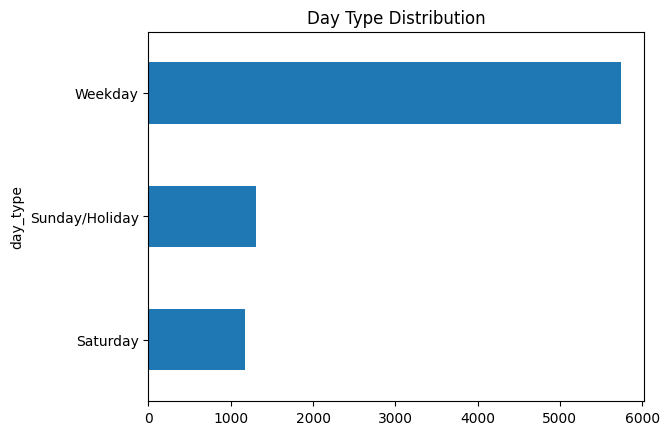

In [12]:
data["day_type"] = data["day_type"].map(
    {"U": "Sunday/Holiday", "W": "Weekday", "A": "Saturday"}
)
data["day_type"].value_counts(ascending=True).plot(
    kind="barh", title="Day Type Distribution"
);

Check that bus and rail ridership sum to total ridership:

In [13]:
np.array_equal(data["bus"] + data["rail_boardings"], data["total_rides"])

True

### Histogram & Summary Statistics

Bus ridership:

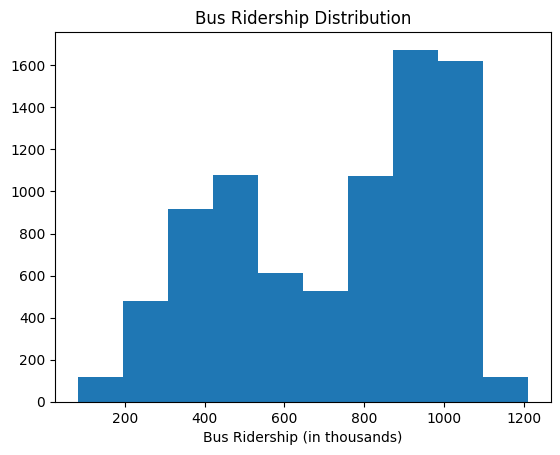

In [14]:
plt.hist(data["bus"] / 1000)
plt.title("Bus Ridership Distribution")
plt.xlabel("Bus Ridership (in thousands)")
plt.show();

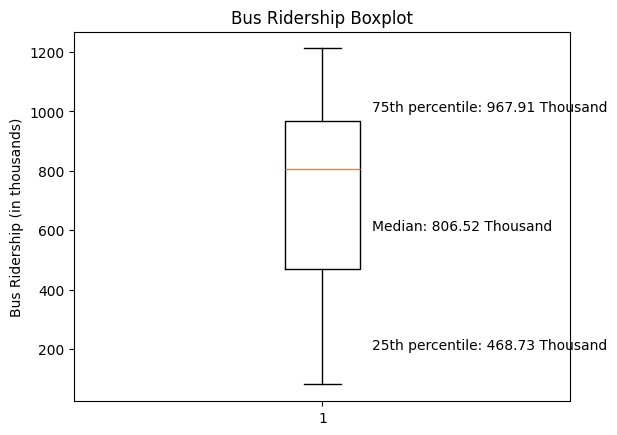

In [15]:
plt.boxplot(data["bus"] / 1000)
plt.title("Bus Ridership Boxplot")
plt.ylabel("Bus Ridership (in thousands)")
plt.text(
    1.1, 1000, f'75th percentile: {data["bus"].quantile(0.75) / 1000:.2f} Thousand'
)
plt.text(1.1, 600, f'Median: {data["bus"].median() / 1000:.2f} Thousand')
plt.text(1.1, 200, f'25th percentile: {data["bus"].quantile(0.25) / 1000:.2f} Thousand')
plt.show();

Rail boarding:

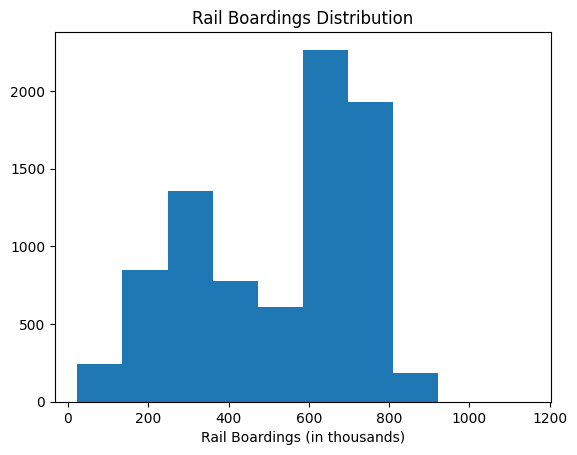

In [16]:
plt.hist(data["rail_boardings"] / 1000)
plt.title("Rail Boardings Distribution")
plt.xlabel("Rail Boardings (in thousands)")
plt.show();

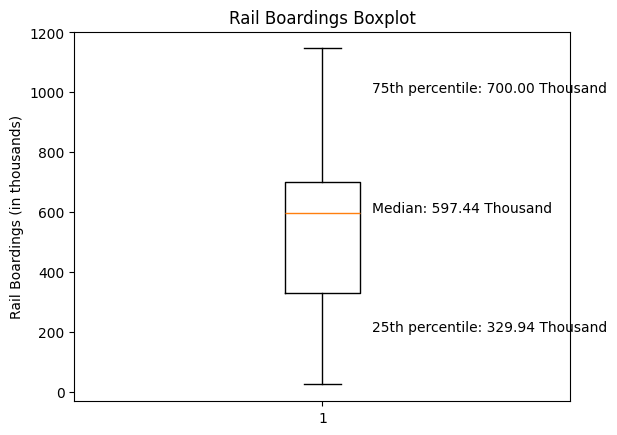

In [17]:
plt.boxplot(data["rail_boardings"] / 1000)
plt.title("Rail Boardings Boxplot")
plt.ylabel("Rail Boardings (in thousands)")
plt.text(
    1.1,
    1000,
    f'75th percentile: {data["rail_boardings"].quantile(0.75) / 1000:.2f} Thousand',
)
plt.text(1.1, 600, f'Median: {data["rail_boardings"].median() / 1000:.2f} Thousand')
plt.text(
    1.1,
    200,
    f'25th percentile: {data["rail_boardings"].quantile(0.25) / 1000:.2f} Thousand',
)
plt.show();

Overlaying histograms:

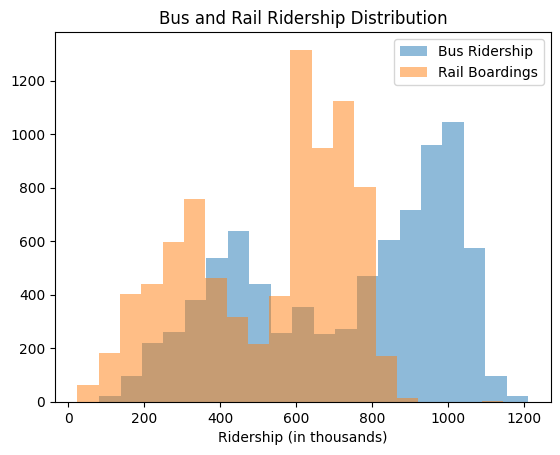

In [18]:
plt.hist(data["bus"] / 1000, bins=20, alpha=0.5, label="Bus Ridership")
plt.hist(data["rail_boardings"] / 1000, bins=20, alpha=0.5, label="Rail Boardings")
plt.title("Bus and Rail Ridership Distribution")
plt.xlabel("Ridership (in thousands)")
plt.legend(loc="upper right")
plt.show();

## Univariate Time Series EDA

### Time Plot, ACF & PACF (Daily Series)

<center>

Exhibit 6.3 General Behavior of the ACF and PACF for ARMA Models
| | AR \(p\) | MA \(q\) | ARMA \(p, q), p>0, and q>0\) |
|---|---|---|---|
| **ACF** | Tails off | Cuts off after lag \(q\) | Tails off |
| **PACF** | Cuts off after lag \(p\) | Tails off | Tails off |

Source: Time Series Analysis With Applications in R

</center>

We plot one year at a time, so we can check for within-the-year trend, seasonality, and variability. The html widget dropdown menu can be used to toggle between years, which is implemented in the `ExploratoryDataAnalyzer` class.

In [19]:
years = range(
    data["service_date"].dt.year.min(), data["service_date"].dt.year.max() + 1
)
years

range(2001, 2024)

In [20]:
eda_helper = ExploratoryDataAnalyzer(data=data)
eda_helper

We will use a lag of $7 \times 8 = 56$ (~ 2 months) since the series is daily frequency:

Dropdown(description='Year:', index=11, options=(2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2…

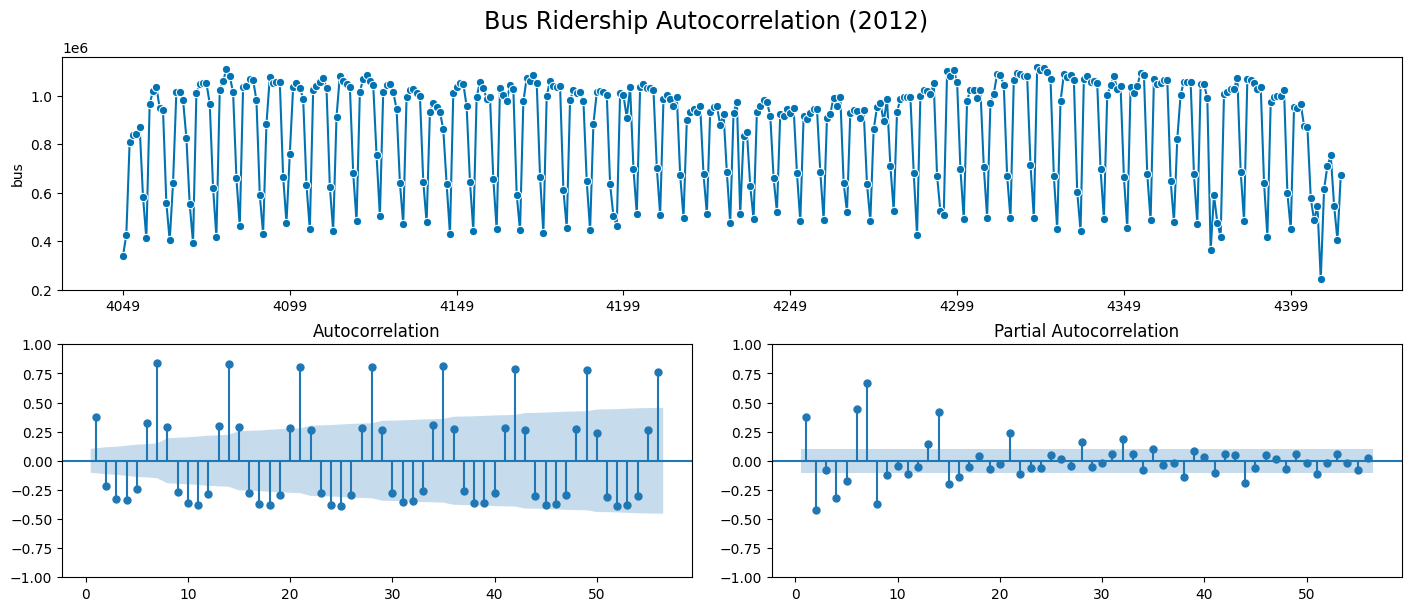

In [21]:
eda_helper.plot_correlations_within_year(
    selections=years,
    var="bus",
    lags=7 * 8,
    suptitle="Bus Ridership Autocorrelation",
    fig_size=(14, 6),
)

Observations:

* The within-the-year plots reveal that there is strong **weekly seasonality** (i.e., 7 daily observations); the ACF plot clearly shows peak-to-peak patterns every 7 lags. This is true for almost every year with some exceptions such as 2015, 2016, and 2017.

* There does not appear to be noticeable within-the-year trends.

* Most years behave like SARMA processes because of statistically significant seasonal lags at 7, 14, 28, etc.

Dropdown(description='Year:', index=20, options=(2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2…

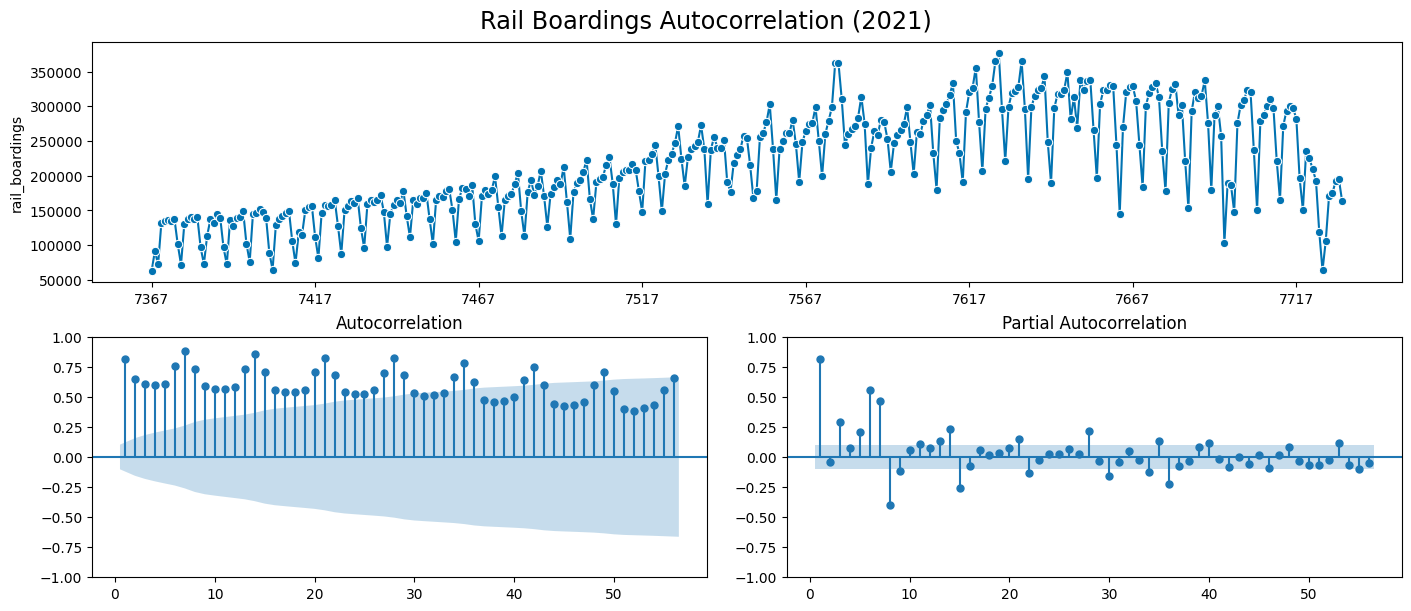

In [22]:
eda_helper.plot_correlations_within_year(
    selections=years,
    var="rail_boardings",
    lags=7 * 8,
    suptitle="Rail Boardings Autocorrelation",
    fig_size=(14, 6),
)

* Similarly, the rail boardings series also exhibits strong weekly seasonality in most years with some exceptions such as 2015, 2016, and 2017.

* While there does not to be within-the-year trends for most years, 2023 data does appear to show some slight positive trend.

### Time Plot, ACF & PACF (Monthly Series)

Because daily observations can make visualizing longer-term trends difficult, we resample the data by taking the monthly median/mean to create monthly observations. For monthly data, we will examine up to 36 lags (3 years).

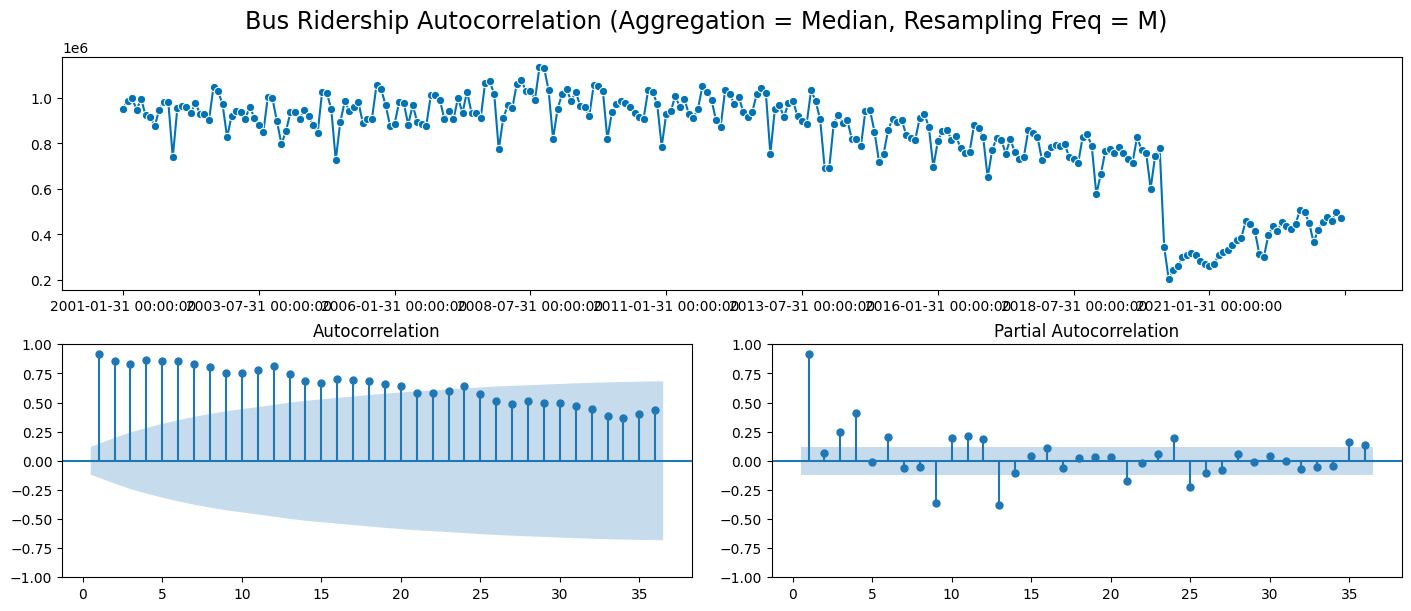

In [23]:
eda_helper.plot_correlations_between_years(
    var="bus",
    lags=36,
    agg_func="median",
    freq="M",
    suptitle="Bus Ridership Autocorrelation",
    fig_size=(14, 6),
)

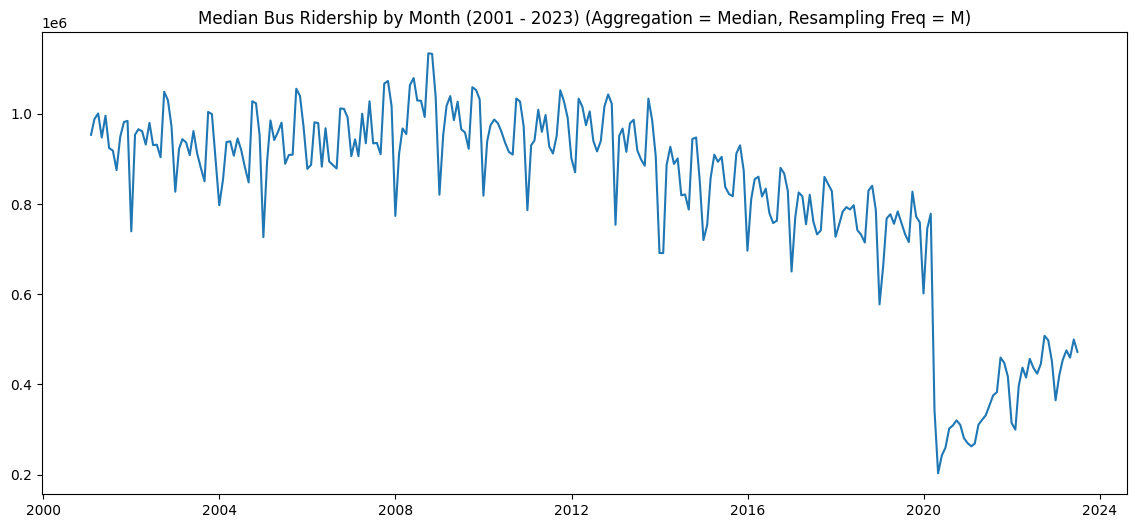

In [24]:
eda_helper.plot_series_between_years(
    var="bus",
    agg_func="median",
    freq="M",
    title="Median Bus Ridership by Month (2001 - 2023)",
    fig_size=(14, 6),
)

* From the ACF and time plots, there certainly appears to be some yearly seasonality as well (i.e., wave-like pattern every 12 lags). Although the patterns are noisier than those of weekly seasonality.

* In the PACF plot, there does appear to be positive and significant lags at 12, 24, and 36.

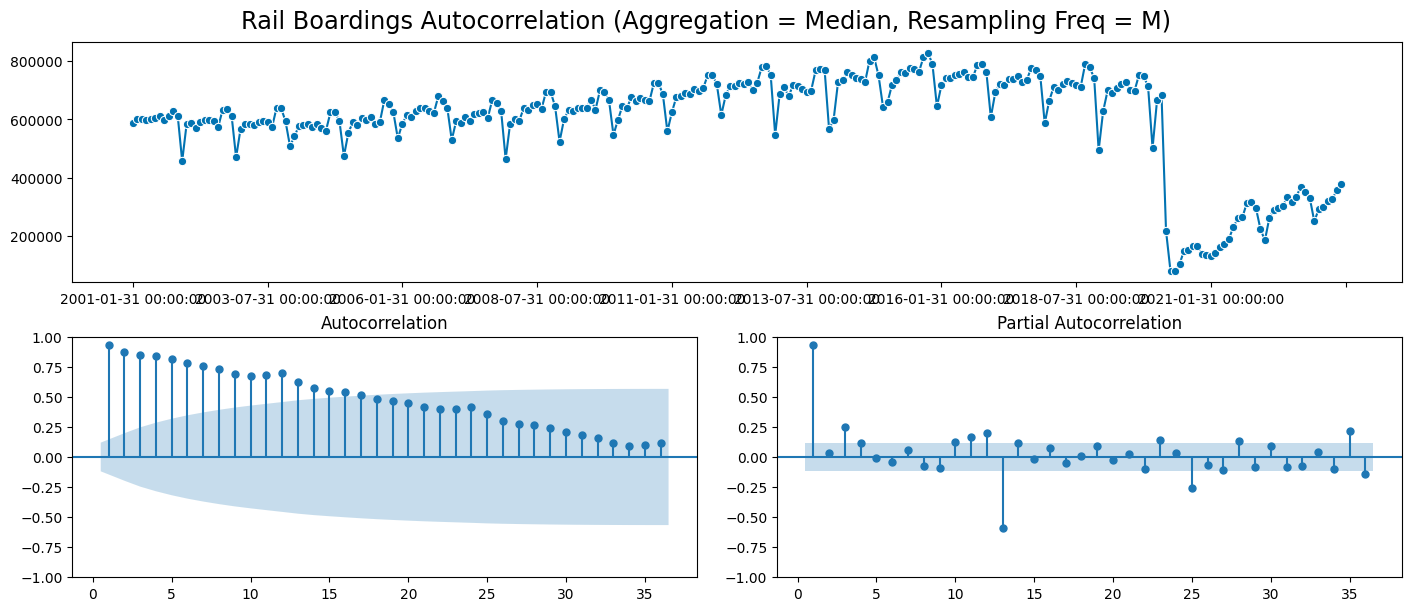

In [25]:
eda_helper.plot_correlations_between_years(
    var="rail_boardings",
    lags=36,
    agg_func="median",
    freq="M",
    suptitle="Rail Boardings Autocorrelation",
    fig_size=(14, 6),
)

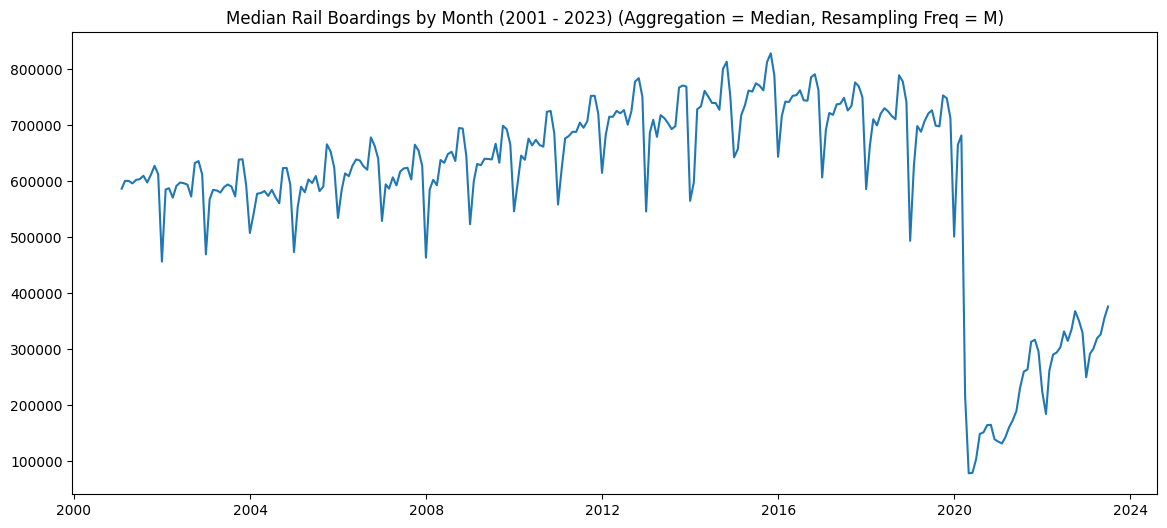

In [26]:
eda_helper.plot_series_between_years(
    var="rail_boardings",
    agg_func="median",
    freq="M",
    title="Median Rail Boardings by Month (2001 - 2023)",
    fig_size=(14, 6),
)

* The yearly seasonality is more noticeable for the rail boardings series than for the bus ridership series. The ACF shows wave-like patterns.

#### Erratic Patterns & Data Due to Unprecedented Events

For both series, there is a noticeable drop in 2020 (Covid 19 Pandemic). This important to consider for our forecasting task since, with the global pandemic, the primary challenge is to ensure that the erratic patterns don't unduly influence the forecast, especially if we assume such events are non-recurring.

  - For shorter forecasting time horizon (e.g. 1 day to 2 weeks ahead), we can probably just build models using more recent. The models can focus on learning and uncovering the shorter-term trends and patterns.

  - For medium (e.g. 2 weeks to 6 months ahead) and longer (e.g. 6 months to several years ahead) forecasting horizons, we need more historical data; however, including data from 2020, 2021, and 2022 may cause the model to learn the pandemic-induced trends and patterns when these events are unprecedented. We can use consider the following techniques:

    - **Exogenous Variables**: We can incorporate external indicators (e.g., covid cases, deaths, and hospitalizations) as exogenous variables in models. This allows the modeling to account for the pandemic's effects without treating it as a long-term pattern.

    - **Scenario Analysis**: We can consider building multiple scenarios — models that include pandemic data and models that don't. This can provide a range of forecasts and allows for better planning.

For forecasting several years ahead, we would probably resample our daily data to monthly data as well. Some reasons are:

  - Data relevancy and noisiness (i.e., daily data may be too noisy for long horizon forecasting task) 

  - Computational resource: higher frequency data require more computation resources, which may limit our modeling selection and validation budget. Resampling to monthly data can enable more experimentations.

### Time Series Decomposition

To better understand trends and seasonalities, we apply Season-Trend decomposition using LOESS for multiple seasonalities ([MSTL](https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html)). Some key parameters are:

* `periods`: The period of each seasonal component (e.g., for daily data with both weekly and yearly seasonality: `periods = (7, 365)`).

* `windows`: The lengths of each seasonal smoother with respect to each period. If these are large then the seasonal component will show less variability over time. This must be an odd integer, and should normally be >= 7 (default). If None, a set of default values determined by experiments in the original MSTL paper are used. 

* `lmbda`: The lambda parameter for a Box-Cox transformation prior to decomposition. If `None` then no transformation is done. If `auto`, then an appropriate value for lambda is automatically selected from the data.

* `iterate`: Number of iterations to use to refine the seasonal component.

* `stl_kwargs`: These are `kwargs` that can be passed to `statsmodels.tsa.seasonal.STL`. For this, we will include the following parameters:

    - `seasonal_deg`: Degree of seasonal LOESS, either 0 (constant) or 1 (constant and trend).

    - `robust`: Flag indicating whether to use a weighted version of LOESS that is robust to some forms of outliers.

In [27]:
# Prepare data for MSTL
bus = pd.Series(data["bus"].values, index=data["service_date"].values).sort_index()
rail = pd.Series(
    data["rail_boardings"].values, index=data["service_date"].values
).sort_index()

#### Bus Ridership

In [28]:
bus_mstl = MSTL(
    endog=bus,
    periods=(7, 365),  # Weekly and yearly seasonality as discovered in EDA
    windows=None,
    lmbda="auto",
    iterate=2,
    stl_kwargs={"seasonal_deg": 1, "robust": True},
)

bus_mstl_res = bus_mstl.fit()

The returned object `statsmodels.tsa.seasonal.DecomposeResult` has the following attributes:

- `nobs`: Number of observations
- `observed`: Observed data
- `resid`: The estimated residuals
- `seasonal`: The estimated seasonal component
- `trend`: The estimated trend component
- `weights`: The weights used in the robust estimation

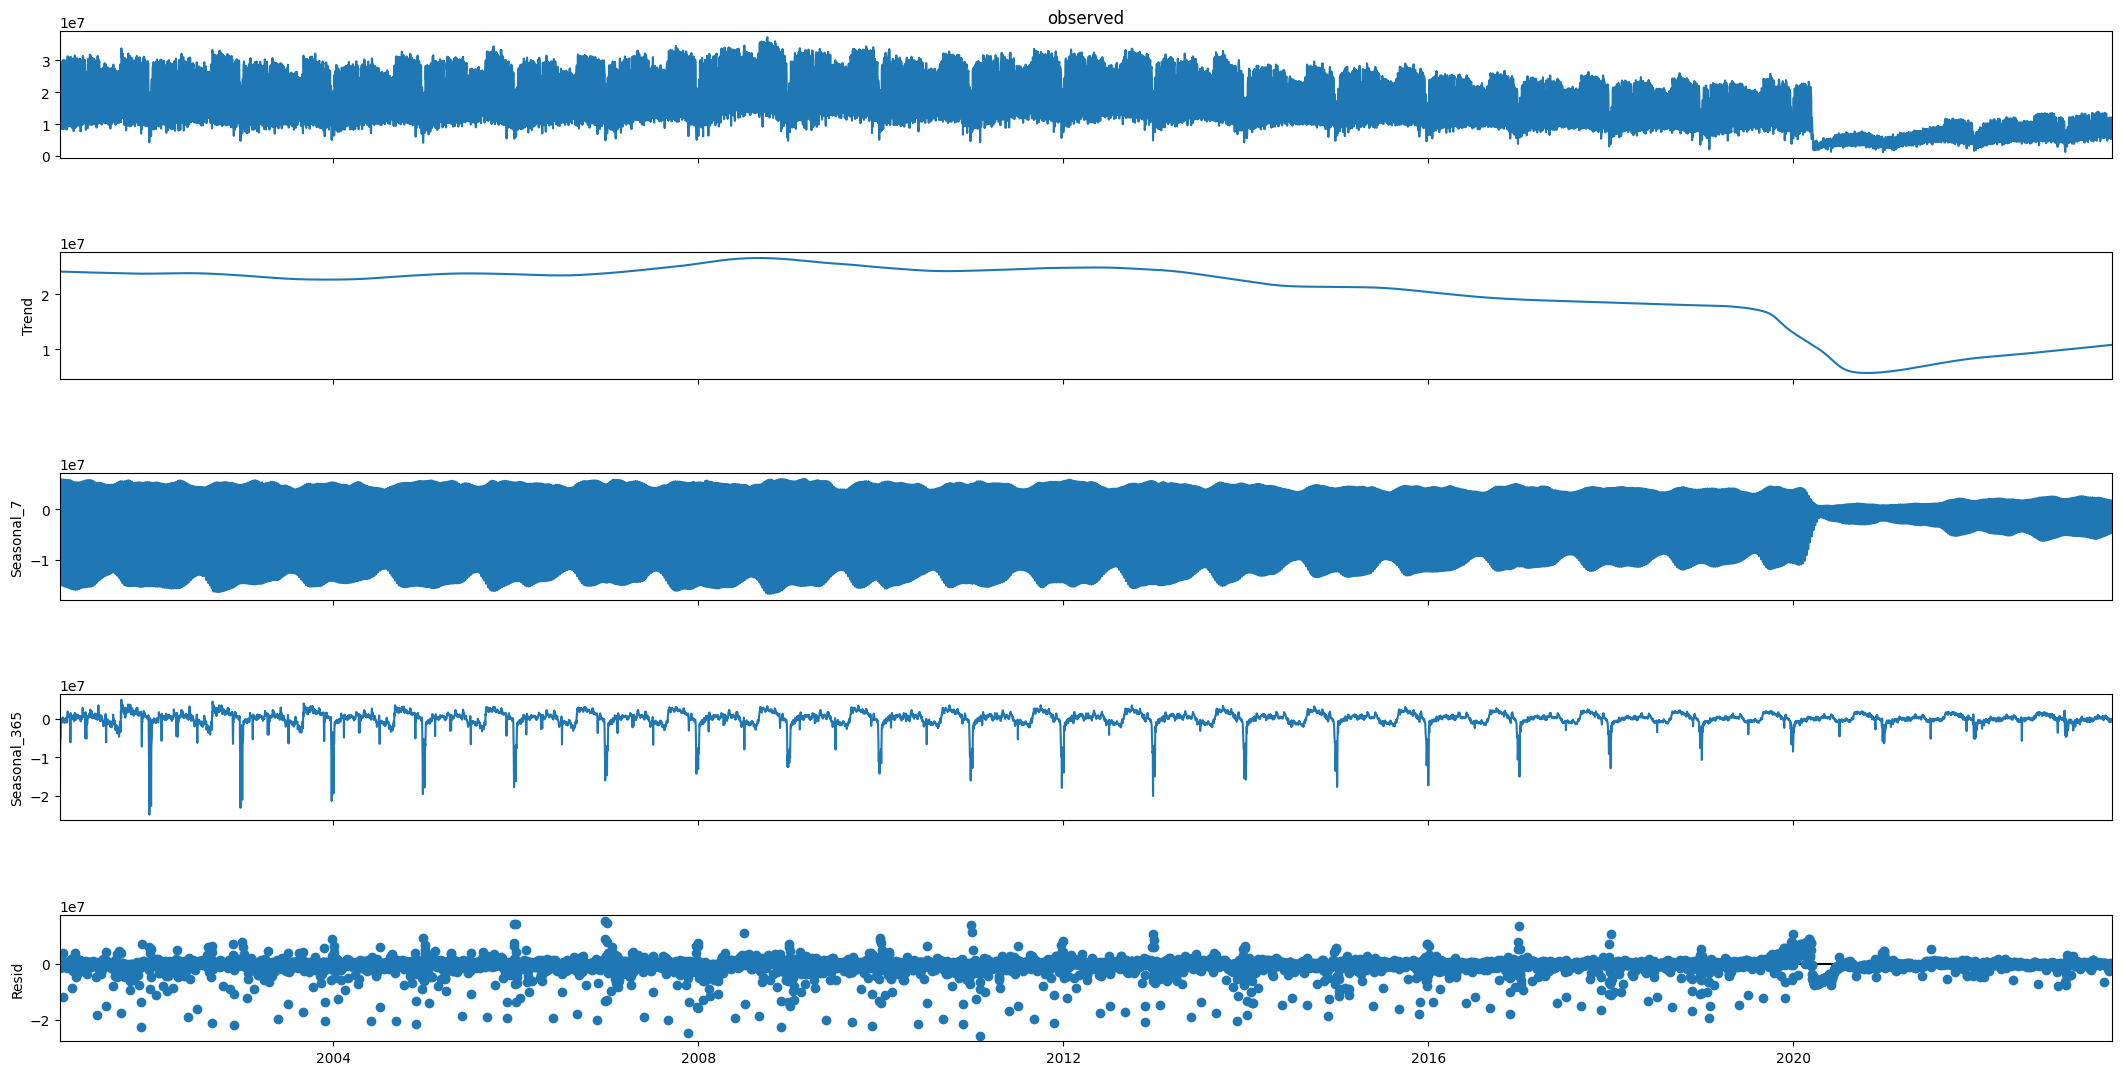

In [29]:
bus_decomp_fig = bus_mstl_res.plot()
bus_decomp_fig.set_size_inches(24, 12)
plt.show();

* There was a constant trend (prior to 2014-2015); from then on, the trend starts to decrease leading up to the start of the pandemic (2020); it is now trending upward again since 2020.

* The yearly and weekly seasonalities are confirmed for years leading up to the pandemic, and the variances do not appear to be constant.

#### Rail Boardings

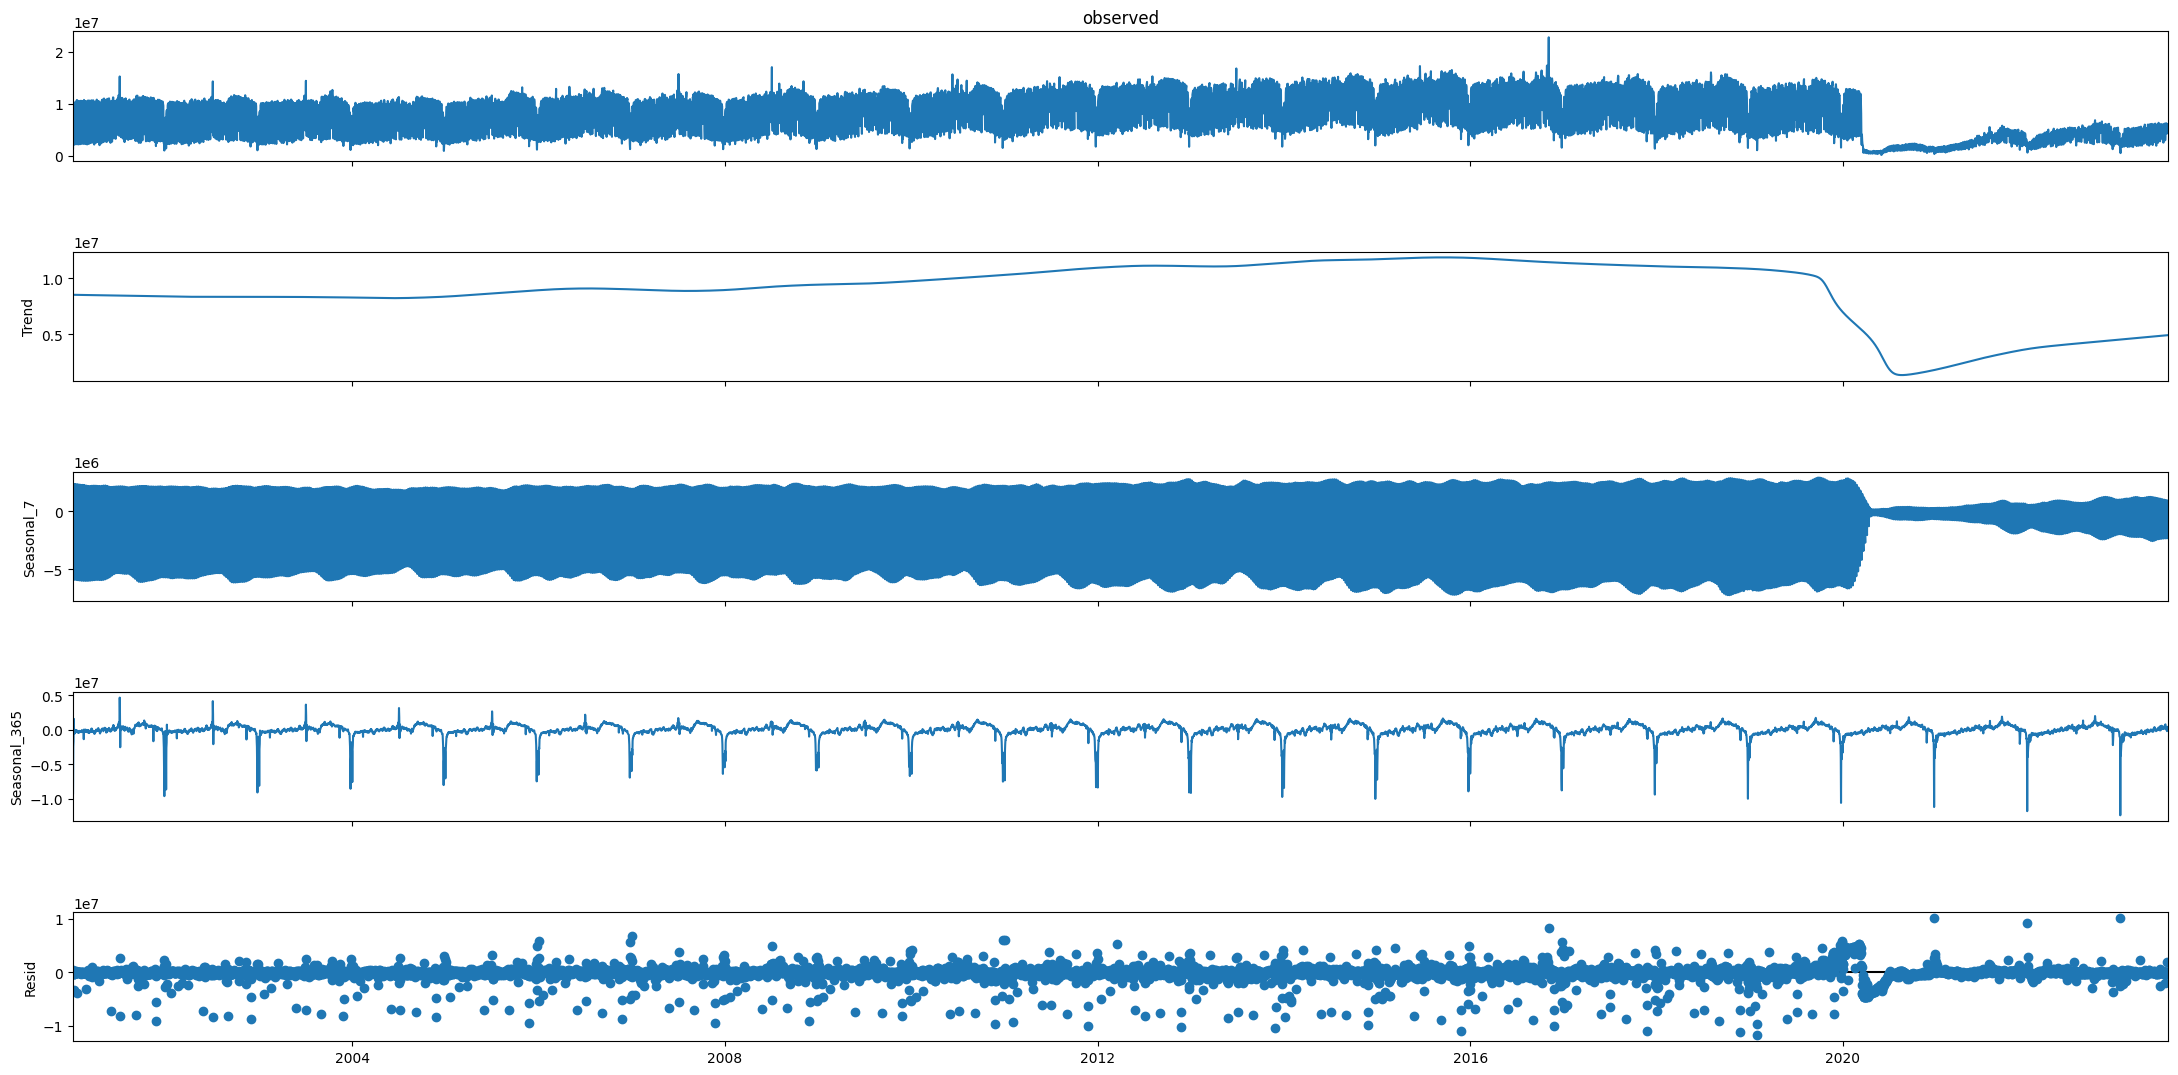

In [30]:
rail_mstl = MSTL(
    endog=rail,
    periods=(7, 365),  # Weekly and yearly seasonality as discovered in EDA
    windows=None,
    lmbda="auto",
    iterate=2,
    stl_kwargs={"seasonal_deg": 1, "robust": True},
)

rail_mstl_res = rail_mstl.fit()

rail_decomp_fig = rail_mstl_res.plot()
rail_decomp_fig.set_size_inches(24, 12)
plt.show();

* Very similar trends and seasonalities are observed from the rail series components as compared to those of the bus series.

    - Fairly constant trend before rapid drop leading up to the pandemic, and then increasing trend in recent years (2021, 2022, 2023).

    - Confirmed weekly and yearly seasonalities; for annual seasonality, variance appears fairly constant over time; for weekly seasonality, variances do not appear to be stable in since the pandemic (2020).

#### Some Conclusions

* SARIMA models should be preferred over than ARIMA.

* In addition, because we have multiple seasonality (weekly and annually), we should consider the [TBATS](https://www.tandfonline.com/doi/abs/10.1198/jasa.2011.tm09771) model, which is an acronym for:

    - Trigonometric seasonality

    - Box-Cox transformation

    - ARMA errors

    - Trend

    - Seasonal components

  TBATS was designed to forecast time series with multiple seasonal periods.

* For longer forecast horizon, we likely need more historical data, and we should consider resampling (downsampling).

* The series are evidently non-stationary, and so data transformations, differencing, and further statistical hypothesis testing should be explored.

### Differencing (Median to Long Forecast Horizon)

To check the orders of differencing required to make the series stationary for median-to-longer term forecasting tasks, we can use the utility functions in the `pmdarima` package. It is also beneficial to pre-compute `d` and `D` ahead of `auto_arima`. First, we apply data transformation to stabilize the variances of the series.

In [31]:
bc_transformer_bus = BoxCoxTransformer(method="mle").fit(X=bus)
bc_transformer_rail = BoxCoxTransformer(method="mle").fit(X=rail)

print("Optimal lambda for bus: ", bc_transformer_bus.lambda_)
print("Optimal lambda for rail: ", bc_transformer_rail.lambda_)

Optimal lambda for bus:  1.2611556762281804
Optimal lambda for rail:  1.2289433692062401


In [32]:
bus_bc = bc_transformer_bus.transform(X=bus)
rail_bc = bc_transformer_rail.transform(X=rail)

Check and apply seasonal differencing first based on [recommendations](https://otexts.com/fpp3/stationarity.html#seasonal-differencing) from Rob Hydnman in 'Forecasting: Principles and Practice':

> However, if the data have a strong seasonal pattern, we recommend that seasonal differencing be done first, because the resulting series will sometimes be stationary and there will be no need for a further first difference.

One more parameter we need to set is `m`, which is the number of seasonal periods (i.e., frequency of the time series). Because we have daily data and there is strong weekly seasonality, we set `m = 7`. Rob Hyndman wrote a very useful [blog](https://robjhyndman.com/hyndsight/seasonal-periods/) on determining seasonal periods. Note that this likely has not captured all the seasonal patterns, because we have multiple seasonalities and both series are long enough to have both seasonalities present over the time window (2001 - 2023).

The test we use is the Canova-Hansen test for seasonal differences. Canova and Hansen (1995) proposed a test statistic for the null hypothesis that the seasonal pattern is stable. The test statistic can be formulated in terms of seasonal dummies or seasonal cycles. The former allows us to identify seasons (e.g. weeks, months, or quarters) that are not stable.

In [33]:
n_seasonal_diffs_bus = nsdiffs(x=bus_bc, m=7, test="ch")
bus_bc_seasonal = diff(x=bus_bc, lag=7, differences=n_seasonal_diffs_bus)
print(f"Bus ridership requires {n_seasonal_diffs_bus} seasonal differencing")

n_seasonal_diffs_rail = nsdiffs(x=rail_bc, m=7, test="ch")
rail_bc_seasonal = diff(x=rail_bc, lag=7, differences=n_seasonal_diffs_rail)
print(f"Rail boardings requires {n_seasonal_diffs_rail} seasonal differencing")

Bus ridership requires 1 seasonal differencing
Rail boardings requires 1 seasonal differencing


Check if another round of first (non-seasonal) differencing is neede:

In [34]:
n_diffs_bus_kpss = ndiffs(x=bus_bc_seasonal, alpha=0.05, test="kpss")
n_diffs_bus_adf = ndiffs(x=bus_bc_seasonal, alpha=0.05, test="adf")
print(
    f"Bus ridership requires {n_diffs_bus_kpss} first differencing based on the KPSS test"
)
print(
    f"Bus ridership requires {n_diffs_bus_adf} first differencing based on the ADF test"
)

n_diffs_rail_kpss = ndiffs(x=rail_bc_seasonal, alpha=0.05, test="kpss")
n_diffs_rail_adf = ndiffs(x=rail_bc_seasonal, alpha=0.05, test="adf")
print(
    f"Rail boardings requires {n_diffs_rail_kpss} first differencing based on the KPSS test"
)
print(
    f"Rail boardings requires {n_diffs_rail_adf} first differencing based on the ADF test"
)

Bus ridership requires 0 first differencing based on the KPSS test
Bus ridership requires 0 first differencing based on the ADF test
Rail boardings requires 0 first differencing based on the KPSS test
Rail boardings requires 0 first differencing based on the ADF test


Visualize the within-the-year ACF & PACF:

In [35]:
transformed_diff_data = pd.DataFrame(
    {
        "service_date": data["service_date"].loc[
            7:
        ],  # We lose the first 7 observations due to differencing
        "bus": bus_bc_seasonal,
        "rail_boardings": rail_bc_seasonal,
    }
)

eda_helper_transformed = ExploratoryDataAnalyzer(data=transformed_diff_data)

#### Bus Ridership

Dropdown(description='Year:', index=18, options=(2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2…

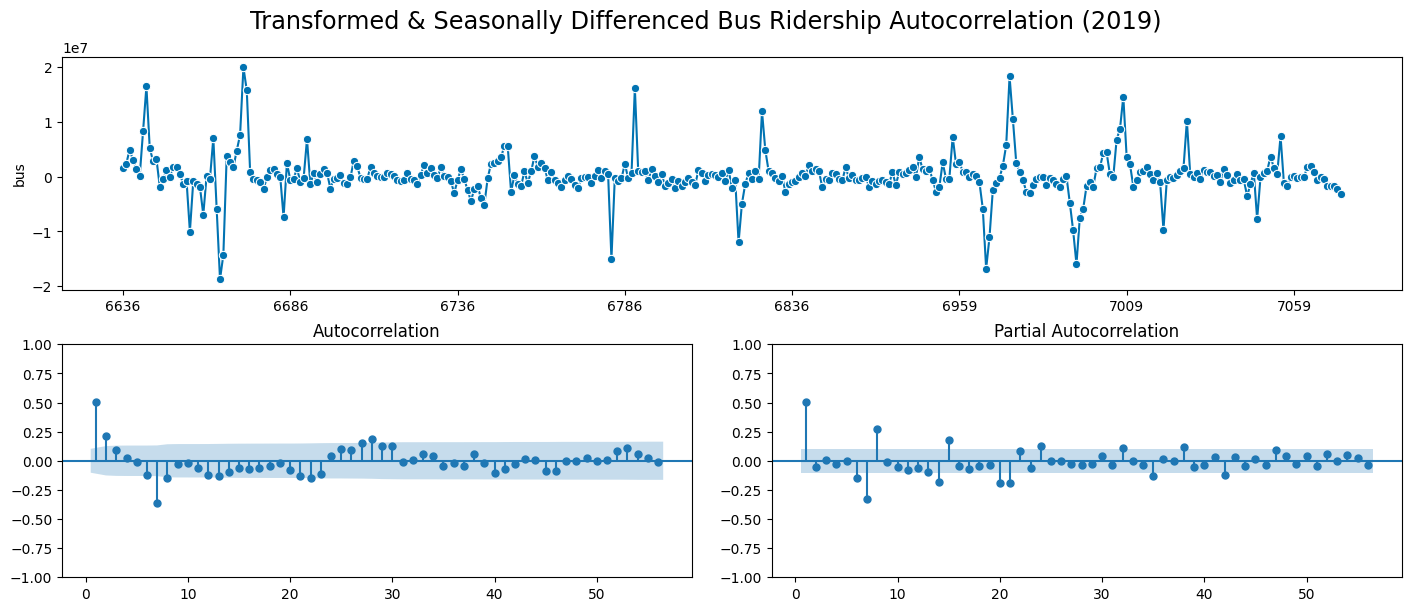

In [36]:
eda_helper_transformed.plot_correlations_within_year(
    selections=years,
    var="bus",
    lags=7 * 8,
    suptitle="Transformed & Seasonally Differenced Bus Ridership Autocorrelation",
    fig_size=(14, 6),
)

#### Rail Boardings

Dropdown(description='Year:', index=22, options=(2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2…

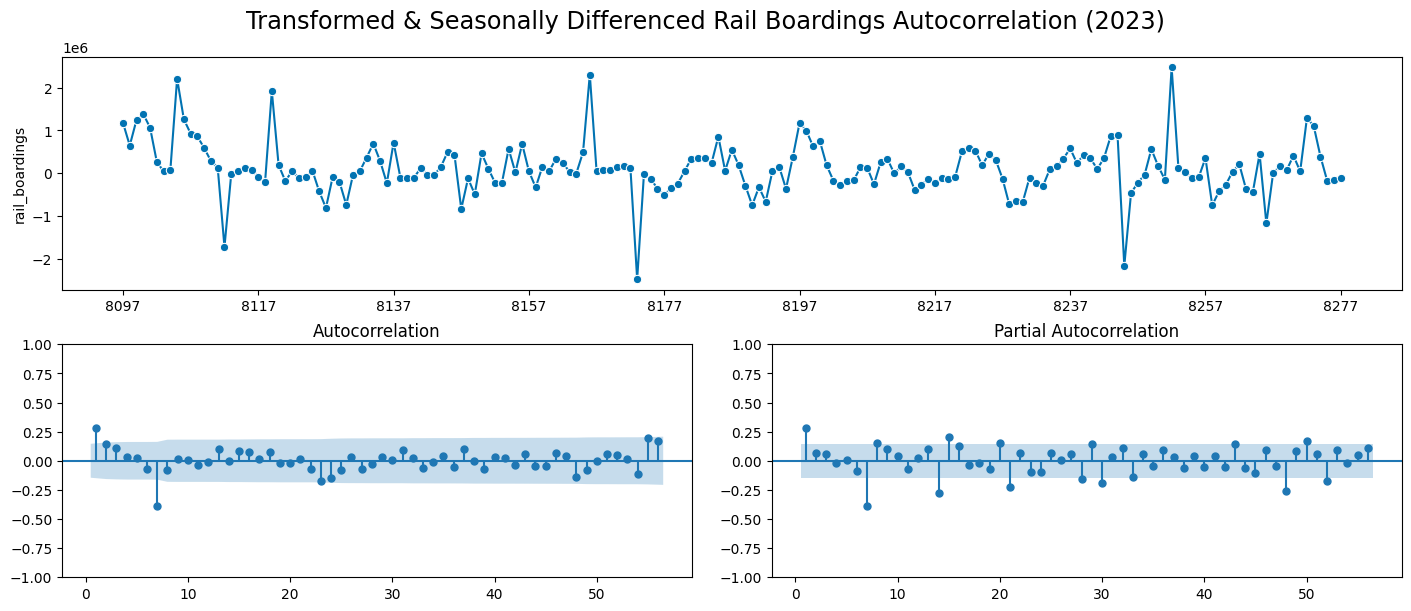

In [37]:
eda_helper_transformed.plot_correlations_within_year(
    selections=years,
    var="rail_boardings",
    lags=7 * 8,
    suptitle="Transformed & Seasonally Differenced Rail Boardings Autocorrelation",
    fig_size=(14, 6),
)

Evidently, the within-the-year series appear to be more stationary for most years.

### Differencing (Short Forecast Horizon)

For short-term forecasting horizon (up to 2 weeks), we can simply use more recent data. According to Rob Hyndman in [Forecasting: Principles and Practice](https://otexts.com/fpp3/long-short-ts.html#forecasting-very-long-time-series):

> If we are only interested in forecasting the next few observations, one simple approach is to throw away the earliest observations and only fit a model to the most recent observations.

In addition, daily data can be challenging since, as we have discovered, they often involve multiple seasonal patterns; therefore, forecasting based on daily data often requires methods that handle such complex seasonality. However, we can work around this challenge by training our models on more recent data. In the section [Daily and sub-daily data](https://otexts.com/fpp3/weekly.html#daily-and-sub-daily-data) of Rob Hydman's online textbook:

> Of course, if the time series is relatively short so that only one type of seasonality is present, then it will be possible to use one of the single-seasonal methods we have discussed in previous chapters (e.g., ETS or a seasonal ARIMA model).

For these reasons above and for the forecasting task involving the shorter horizon, we will limit our training data to 2023 observations only.

In [38]:
data_2023_subset = data.loc[data["service_date"] >= pd.to_datetime("2023-01-01")]
bus_2023 = pd.Series(
    data_2023_subset["bus"].values, index=data_2023_subset["service_date"].values
).sort_index()
rail_2023 = pd.Series(
    data_2023_subset["rail_boardings"].values,
    index=data_2023_subset["service_date"].values,
).sort_index()
data_2023_subset.shape

(181, 5)

Apply box-cox transformation:

In [39]:
bc_transformer_bus_2023 = BoxCoxTransformer(method="mle").fit(X=bus_2023)
bc_transformer_rail_2023 = BoxCoxTransformer(method="mle").fit(X=rail_2023)
bus_2023_bc = bc_transformer_bus_2023.transform(X=bus_2023)
rail_2023_bc = bc_transformer_rail_2023.transform(X=rail_2023)
print("Optimal lambda for bus (2023): ", bc_transformer_bus_2023.lambda_)
print("Optimal lambda for rail (2023): ", bc_transformer_rail_2023.lambda_)

Optimal lambda for bus (2023):  2.6929433070981235
Optimal lambda for rail (2023):  2.2282513411075304


Check number of seasonal differencing required:

In [40]:
n_seasonal_diffs_bus_2023 = nsdiffs(x=bus_2023_bc, m=7, test="ocsb")
print(f"Bus ridership requires {n_seasonal_diffs_bus_2023} seasonal differencing")

Bus ridership requires 0 seasonal differencing


In [41]:
n_seasonal_diffs_rail_2023 = nsdiffs(x=rail_2023_bc, m=7, test="ch")
print(f"Rail boardings requires {n_seasonal_diffs_rail_2023} seasonal differencing")

Rail boardings requires 0 seasonal differencing


Check number of non-seasonal differencing required:

In [42]:
n_diffs_bus_2023_kpss = ndiffs(x=bus_2023_bc, alpha=0.05, test="kpss")
n_diffs_bus_2023_adf = ndiffs(x=bus_2023_bc, alpha=0.05, test="adf")
print(
    f"Bus ridership requires {n_diffs_bus_2023_kpss} first differencing based on the KPSS test"
)
print(
    f"Bus ridership requires {n_diffs_bus_2023_adf} first differencing based on the ADF test"
)

Bus ridership requires 1 first differencing based on the KPSS test
Bus ridership requires 0 first differencing based on the ADF test


In [43]:
n_diffs_rail_2023_kpss = ndiffs(x=rail_2023_bc, alpha=0.05, test="kpss")
n_diffs_rail_2023_adf = ndiffs(x=rail_2023_bc, alpha=0.05, test="adf")
print(
    f"Rail boardings requires {n_diffs_rail_2023_kpss} first differencing based on the KPSS test"
)
print(
    f"Rail boardings requires {n_diffs_rail_2023_adf} first differencing based on the ADF test"
)

Rail boardings requires 1 first differencing based on the KPSS test
Rail boardings requires 0 first differencing based on the ADF test


Visualize ACF & PACF for both differenced and non-differenced series (since the ADF and SKPSS test disagrees):

In [44]:
# (Non-seasonal) Differenced and transformed series
bus_2023_bc_diff = pd.Series(
    diff(x=bus_2023_bc, lag=1, differences=n_diffs_rail_2023_kpss),
    index=bus_2023_bc.index[1:],
)  # We lose the first observation due to differencing
rail_2023_bc_diff = pd.Series(
    diff(x=rail_2023_bc, lag=1, differences=n_diffs_rail_2023_kpss),
    index=rail_2023_bc.index[1:],
)  # We lose the first observation due to differencing

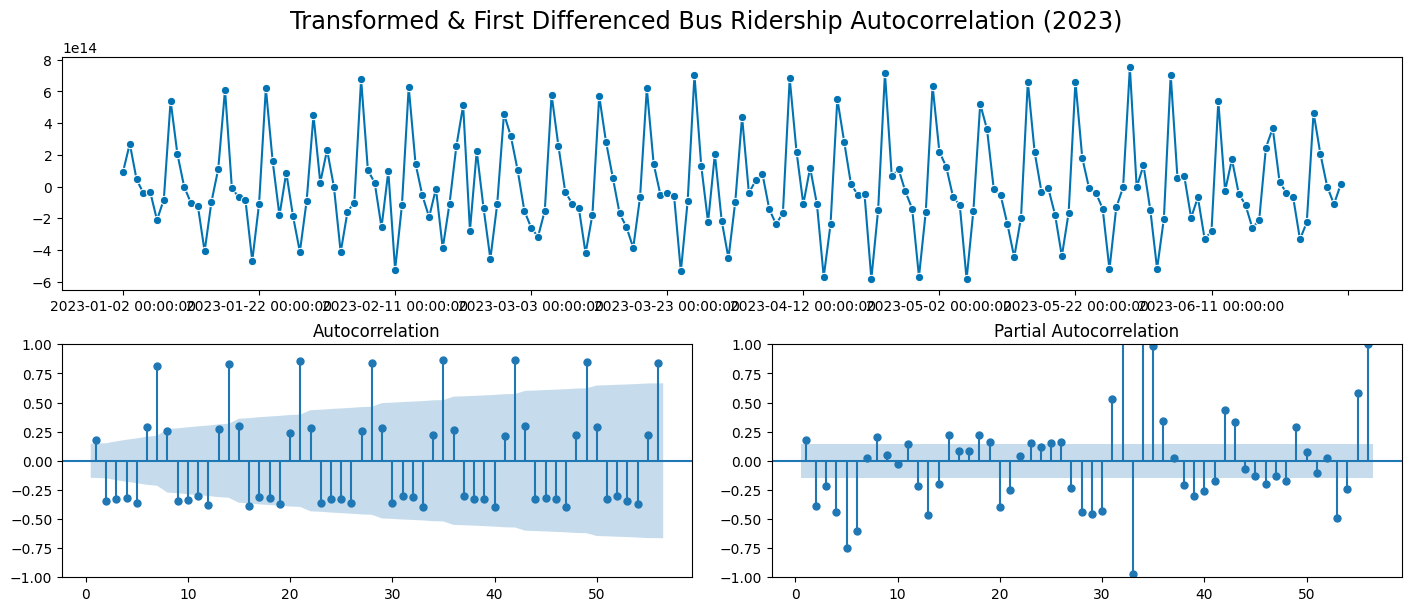

In [45]:
ExploratoryDataAnalyzer.plot_correlations(
    series=bus_2023_bc_diff,
    lags=7 * 8,
    suptitle="Transformed & First Differenced Bus Ridership Autocorrelation (2023)",
    fig_size=(14, 6),
)

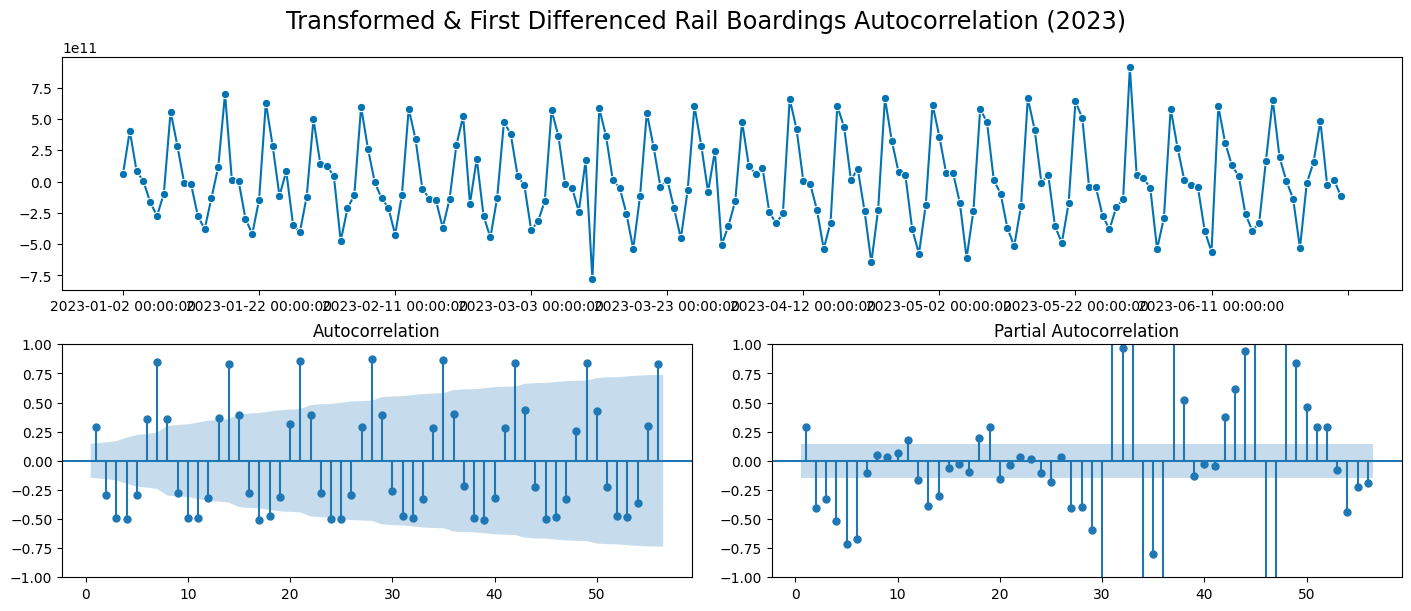

In [46]:
ExploratoryDataAnalyzer.plot_correlations(
    series=rail_2023_bc_diff,
    lags=7 * 8,
    suptitle="Transformed & First Differenced Rail Boardings Autocorrelation (2023)",
    fig_size=(14, 6),
)

The transformed and first differenced series do not appear to be stationary, so we will try force taking a round of seasonal differencing:

In [47]:
bus_2023_bc_seasonal_diff = pd.Series(
    diff(x=bus_2023_bc, lag=7, differences=1), index=bus_2023_bc.index[7:]
)  # We lose the first 7 observations due to differencing
rail_2023_bc_seasonal_diff = pd.Series(
    diff(x=rail_2023_bc, lag=7, differences=1), index=rail_2023_bc.index[7:]
)  # We lose the first 7 observations due to differencing

Check again if first-differencing is required:

In [48]:
n_diffs_bus_2023_kpss = ndiffs(x=bus_2023_bc_seasonal_diff, alpha=0.05, test="kpss")
n_diffs_bus_2023_adf = ndiffs(x=bus_2023_bc_seasonal_diff, alpha=0.05, test="adf")
print(
    f"Bus ridership requires {n_diffs_bus_2023_kpss} first differencing based on the KPSS test"
)
print(
    f"Bus ridership requires {n_diffs_bus_2023_adf} first differencing based on the ADF test"
)

Bus ridership requires 0 first differencing based on the KPSS test
Bus ridership requires 0 first differencing based on the ADF test


In [49]:
n_diffs_rail_2023_kpss = ndiffs(x=rail_2023_bc_seasonal_diff, alpha=0.05, test="kpss")
n_diffs_rail_2023_adf = ndiffs(x=rail_2023_bc_seasonal_diff, alpha=0.05, test="adf")
print(
    f"Rail boardings requires {n_diffs_rail_2023_kpss} first differencing based on the KPSS test"
)
print(
    f"Rail boardings requires {n_diffs_rail_2023_adf} first differencing based on the ADF test"
)

Rail boardings requires 0 first differencing based on the KPSS test
Rail boardings requires 0 first differencing based on the ADF test


Visualize:

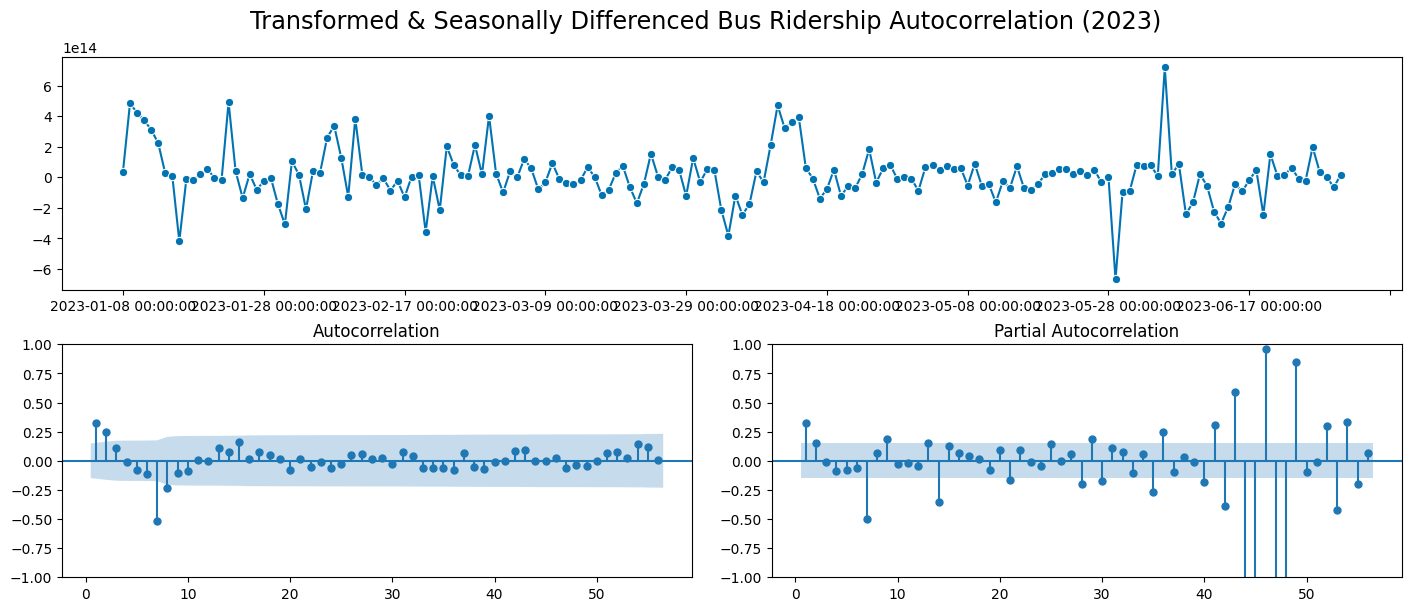

In [50]:
ExploratoryDataAnalyzer.plot_correlations(
    series=bus_2023_bc_seasonal_diff,
    lags=7 * 8,
    suptitle="Transformed & Seasonally Differenced Bus Ridership Autocorrelation (2023)",
    fig_size=(14, 6),
)

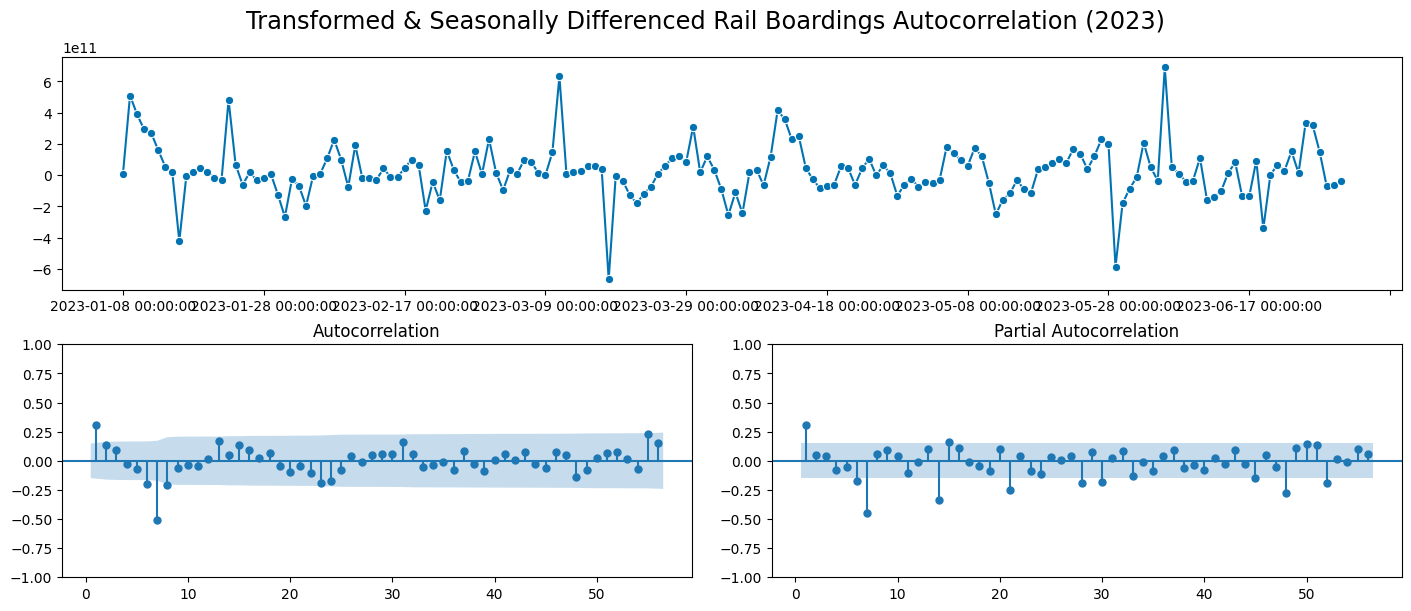

In [51]:
ExploratoryDataAnalyzer.plot_correlations(
    series=rail_2023_bc_seasonal_diff,
    lags=7 * 8,
    suptitle="Transformed & Seasonally Differenced Rail Boardings Autocorrelation (2023)",
    fig_size=(14, 6),
)

Now these series appear to be more stationary after forcing 1 order of seasonal differencing.

## Multivariate Time Series EDA

### Cross-Correlation

To better understand the potential dependencies between the two series--- bus and rail--- we can use the (sample) cross-correlation of between the values of these two series at different times, as a function of the two times. The correlation with lag $\mathrm{k}$ is defined as 

$$\sum_n x[n+k] \cdot y^*[n]$$ 

where $y^*$ is the complex conjugate of $y$.

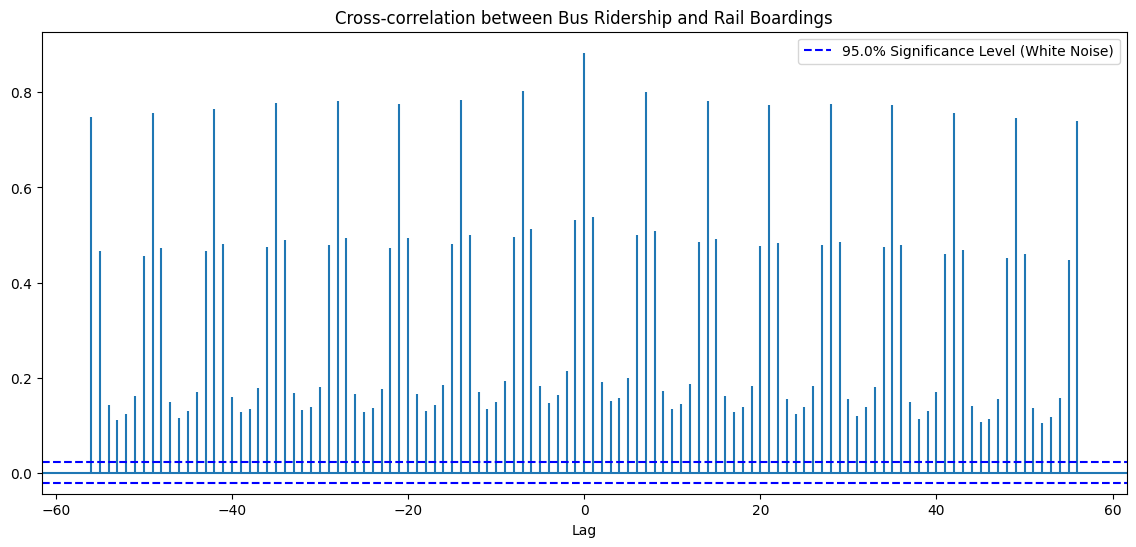

In [52]:
ExploratoryDataAnalyzer.plot_ccf(
    x=bus,
    y=rail,
    maxlags=7 * 8,
    title="Cross-correlation between Bus Ridership and Rail Boardings",
    fig_size=(14, 6),
    ci=0.95,
)

As can be seen, the bus and rail series are positively correlated for both positive and negative lags (i.e., when one goes up the other also increases). The positive correlations are the strongest at every 7th lags (i.e., 7, 14, 21, etc.). However, even the lags that are further away from 0 both in the past and in the future are still statistically significant. This suggests that the two series both lead and lag each other. They are strongly and positively correlated.

For the 2023 subset:

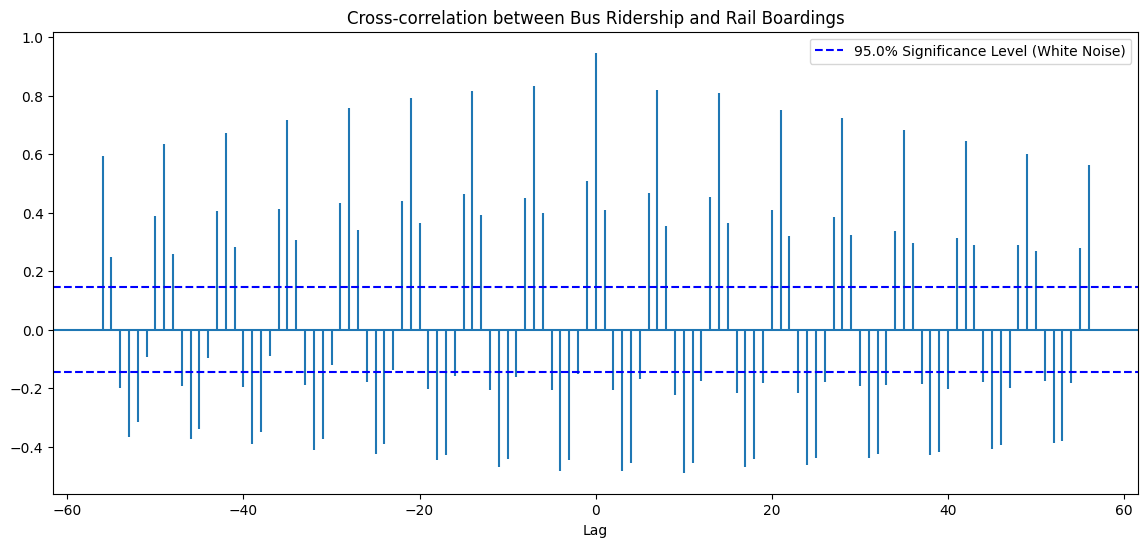

In [53]:
ExploratoryDataAnalyzer.plot_ccf(
    x=data_2023_subset["bus"],
    y=data_2023_subset["rail_boardings"],
    maxlags=7 * 8,
    title="Cross-correlation between Bus Ridership and Rail Boardings",
    fig_size=(14, 6),
    ci=0.95,
)

For the 2023 subset, the sample cross-correlation between the rail and bus series fluctuate between positive and negative depending on the lags. This is a pattern that stands in contrast with the overall time period.

### Granger Causality

The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another, first proposed in 1969.

Given a data matrix with two time series as its two columns, the null hypothesis for the Granger causality test is that the time series in the second column, $x_2$, **does not** Granger cause the time series in the first column, $x_1$. 

Grange causality means that the past values of $x_2$ have a statistically significant effect on the current value of $x_1$, taking past values of $x_1$ into account as regressors.

We reject the null hypothesis that $x_2$ does not Granger cause $x_1$ if the p-values are below a desired size of the test. In other words, the null hypotheses for the set of four tests is that the coefficients corresponding to past values of the second time series are zero.


The returned object is a dictionary:

* The keys are the lag numbers 1, ...., `maxlags`
  * The value for a given lag is a tuple with two elements:
    * Dictionary with keys that are names of the tests and values that are tuples `(test statistic, p-value, degrees of freedom)`
    * A list containing OLS estimation results for the 1) restricted model, 2) the unrestricted model and 3) the restriction (contrast) matrix for the parameter `f_test`

We are interested in the p-values, which can be extracted for each lag `i = 0, ..., len(maxlags)` with `result[i + 1][0]['test_name'][1]`:

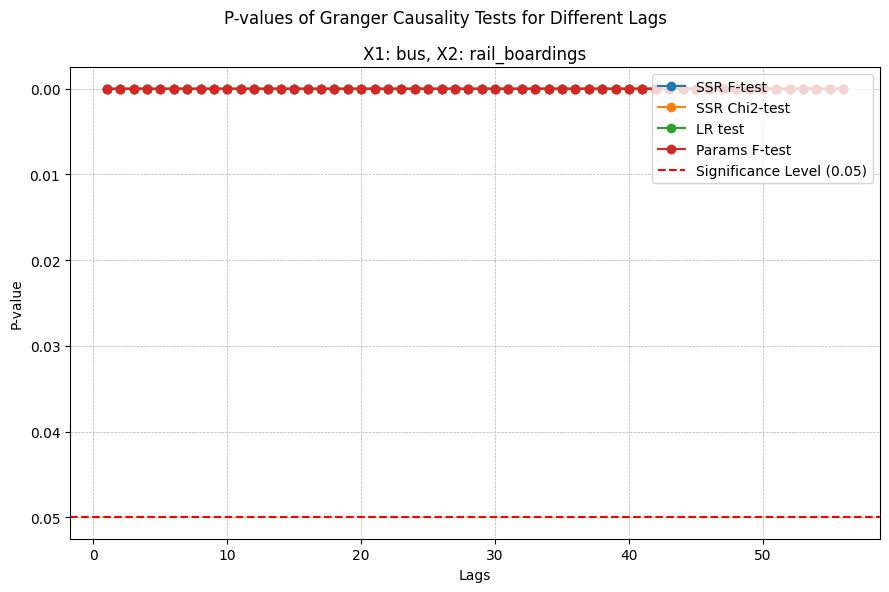

In [54]:
ExploratoryDataAnalyzer.plot_granger_causality(
    data=pd.DataFrame({"bus": bus_bc, "rail_boardings": rail_bc}),
    maxlags=7 * 8,
    fig_size=(9, 6),
)

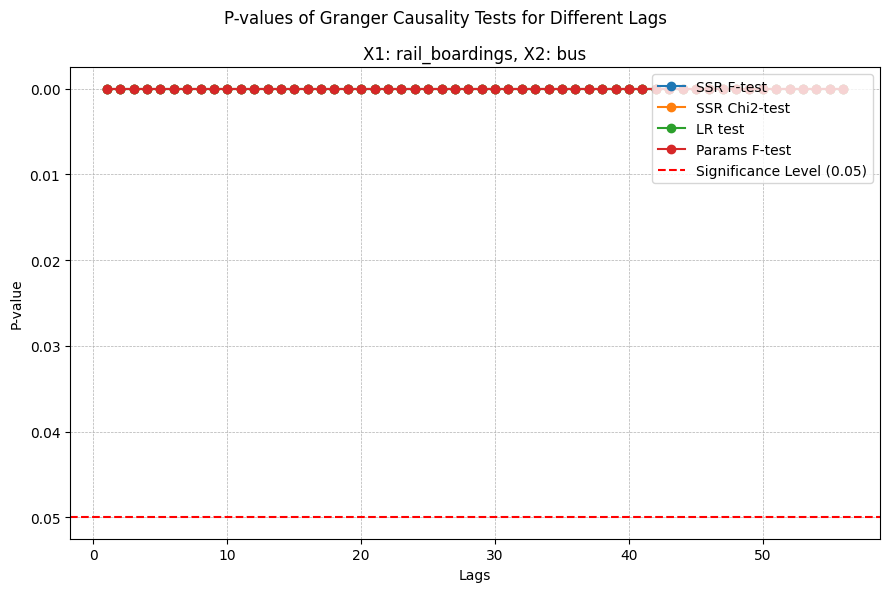

In [55]:
ExploratoryDataAnalyzer.plot_granger_causality(
    data=pd.DataFrame({"rail_boardings": rail_bc, "bus": bus_bc}),
    maxlags=7 * 8,
    fig_size=(9, 6),
)

For all four tests, across all 56 lags (8 weeks), we reject the null hypotheses, concluding that both the bus and the rail series Granger cause (or, more precisely, Granger forecast) each other.

If we restrict our tests to just 2023 data:

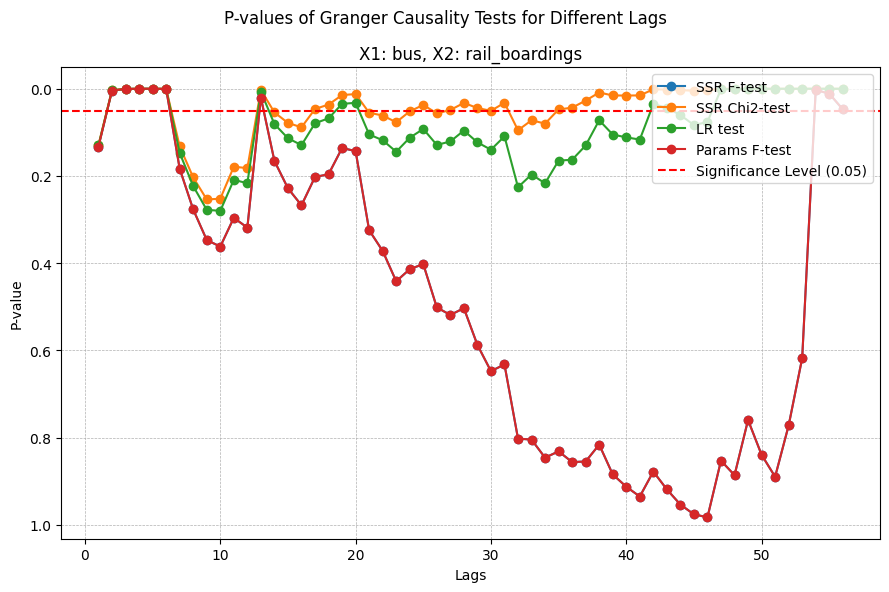

In [56]:
ExploratoryDataAnalyzer.plot_granger_causality(
    data=pd.DataFrame({"bus": bus_2023_bc, "rail_boardings": rail_2023_bc}),
    maxlags=7 * 8,
    fig_size=(9, 6),
)

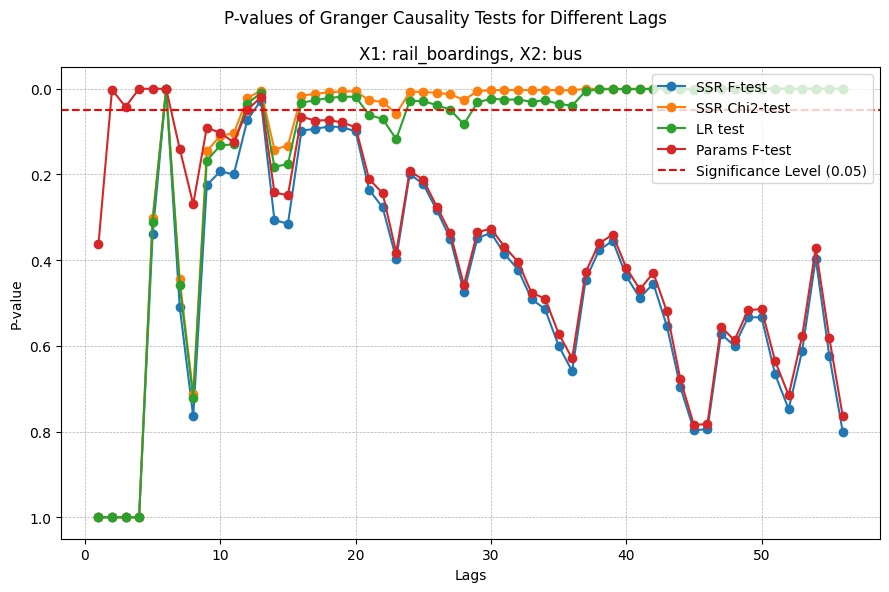

In [57]:
ExploratoryDataAnalyzer.plot_granger_causality(
    data=pd.DataFrame({"rail_boardings": rail_2023_bc, "bus": bus_2023_bc}),
    maxlags=7 * 8,
    fig_size=(9, 6),
)

The test results for the 2023 subset reveal a different story:

* Note every test for every single lag has statistically significant p-values (i.e., we reject the null hypotheses of no Granger causality)

* For this subset, the order of the columns led to noticeably different results. For smaller lags, the evidence points to the conclusion that the past values of rail boardings have statistically significant effect on the current values of bus ridership.

### Conditional Distributions & Time Plot By Day Type

Finally, to better understand the way in which `day_type` affects bus ridership and rail boardings, we plot the conditional distributions and time plots of these series by day type. We can further filter this by year, which allows us to analyze the impact of day type at a more granular level:

Dropdown(description='Year:', index=22, options=(2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2…

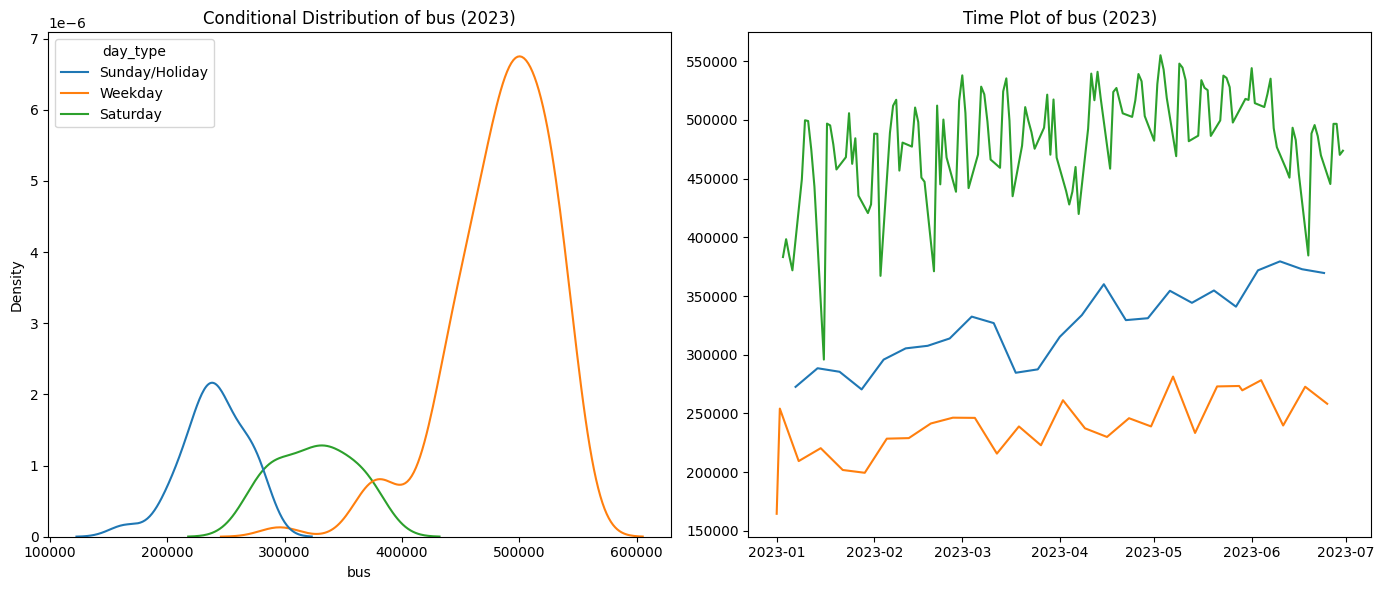

In [58]:
eda_helper.plot_conditional_distribution_and_timeplot(
    selections=years, var="bus", fig_size=(14, 6)
)

Evidently, the day type has a huge impact on bus ridership and rail boardings. 